# RAG System Evaluation Framework

This notebook implements a Retrieval-Augmented Generation (RAG) evaluation framework for comparing different embedding models. It loads documents, processes them, evaluates various embedding models, and visualizes the results.

In [20]:
!pip install colab-xterm
%load_ext colabxterm
%xterm

The colabxterm extension is already loaded. To reload it, use:
  %reload_ext colabxterm


Launching Xterm...

<IPython.core.display.Javascript object>

## Setup and Dependencies

Install the required libraries for document loading, text splitting, embedding generation, and model evaluation.

In [12]:
%pip install langchain langchain_community langchain_ollama langchain_text_splitters langchain_huggingface

## Document Loading

Load text documents from a specified directory to use as the knowledge base for our RAG system.

In [21]:
from langchain_community.document_loaders import DirectoryLoader
from langchain_community.document_loaders import TextLoader

# Load all text files from the processed_data directory
# folder_path = "/workspaces/RAG_BOT/processed_data"
folder_path = "/content/sample_doc"
document_loader = DirectoryLoader(folder_path, glob="**/*.txt", loader_cls=TextLoader)
raw_documents = document_loader.load()

print(f"Number of documents loaded: {len(raw_documents)}")
print("Documents loaded:")
print(raw_documents)

Number of documents loaded: 1
Documents loaded:
[Document(metadata={'source': '/content/sample_doc/PolicyMangement.txt'}, page_content='ENDPOINT: Delete authentication profile\nPATH: /AuthProfile/DeleteProfile\nMETHOD: POST\nTAGS: Authentication Profile\nMETADATA:\n  * x-idap-anon: False\n  * x-codegen-request-body-name: payload\nPARAMETERS:\n  * uuid (query, Required): Authentication UUID.\nREQUEST BODY: Required\n  Content Type: application/json\n  Schema Properties:\n    * uuid (string): The authentication profile uuid either passed in by method call or as part of the payload.\n    Required fields: uuid\n  Sample Request JSON:\n  ```json\n  {\n  "uuid": "string_value"\n}\n  ```\nRESPONSES:\n  Status Code: 200\n  Description: API-Result\n  Content Type: */*\n  Response Schema: AuthProfileDeleteProfile\n  Response Body Properties:\n    * Result (boolean): Success or failure of the delete\n    * Error (object): Error message text on failure, may be null\n  Sample Response JSON:\n  ```j

## Document Processing

Split the loaded documents into smaller chunks based on delimiter patterns (dashed lines) to create more manageable and context-specific documents for embedding and retrieval.

In [22]:
import re
from langchain_core.documents import Document

# Split each raw document based on dashed line and create sub-documents
split_documents = []
for doc in raw_documents:
    # Use regex to split based on dashed lines like '-----...'
    parts = re.split(r'-{5,}', doc.page_content)
    for i, part in enumerate(parts):
        cleaned_part = part.strip()
        if cleaned_part:
            split_documents.append(
                Document(
                    page_content=cleaned_part,
                    metadata={"source": doc.metadata["source"], "part": i + 1}
                )
            )

print(f"Total split chunks: {len(split_documents)}")

Total split chunks: 9


## Test Queries Setup

Define test queries to evaluate the performance of different embedding models. These queries will be used to test retrieval effectiveness.

In [23]:

from langchain_ollama import OllamaEmbeddings
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_core.documents import Document
import pandas as pd
import matplotlib.pyplot as plt
import time
import numpy as np
from sklearn.metrics import ndcg_score

# Define test queries with known relevant document IDs (if available)
test_queries = [
    {"query": "how to get a policy?", "relevant_docs": []},  # Add document IDs if you know ground truth
    {"query": "What is request body needed for https://{tenant_url}/Policy/SavePolicyBlock3", "relevant_docs": []},
    {"query": "delete a policy", "relevant_docs": []}
]


## Evaluation Function

Define a function to evaluate embedding models by measuring:
1. Embedding generation time
2. Query response time
3. Relevance of retrieved documents
4. Overall performance metrics

In [24]:
def evaluate_embedding_model(model_name, embedding_model, documents, test_queries, k=5):
    # Time the embedding creation
    start_time = time.time()
    vector_store = InMemoryVectorStore.from_documents(documents, embedding_model)
    embedding_time = time.time() - start_time

    results = []
    model_metrics = {
        "model": model_name,
        "embedding_time": embedding_time,
        "doc_count": len(vector_store.store),
        "queries": []
    }

    # Test each query
    for test_case in test_queries:
        query = test_case["query"]
        print(f"\nQuery: '{query}'")

        # Time the query execution
        start_time = time.time()
        search_results = vector_store.similarity_search_with_score(query, k=k)
        query_time = time.time() - start_time

        # Extract results and scores
        retrieved_docs = []
        for i, (doc, score) in enumerate(search_results, start=1):
            doc_id = f"{doc.metadata.get('source', 'unknown')}:{doc.metadata.get('part', 'unknown')}"
            retrieved_docs.append({
                "rank": i,
                "doc_id": doc_id,
                "score": score,
                "content": doc.page_content[:150] + "..." if len(doc.page_content) > 150 else doc.page_content
            })
            print(f"  Result {i} (Score: {score}):")
            print(f"  {doc.page_content[:150]}...")
            print(f"  {'-' * 40}")

            # Add to full results for dataframe
            results.append({
                "model": model_name,
                "query": query,
                "rank": i,
                "score": score,
                "doc_id": doc_id,
                "content": doc.page_content[:150] + "..." if len(doc.page_content) > 150 else doc.page_content,
                "query_time": query_time
            })

        # Calculate metrics for this query
        query_metrics = {
            "query": query,
            "query_time": query_time,
            "top_score": search_results[0][1] if search_results else None,
            "retrieved_docs": retrieved_docs
        }
        model_metrics["queries"].append(query_metrics)

    return results, model_metrics

## Model Evaluation

Configure and evaluate multiple embedding models:
1. Llama 3.2 (4096 dimensions)
2. Nomic Embed (768 dimensions)
3. HuggingFace MiniLM (384 dimensions)

The evaluation captures performance metrics for each model across all test queries.

In [25]:
# Prepare documents with consistent metadata
documents = [
    Document(
        page_content=chunk.page_content,
        metadata=chunk.metadata
    ) for chunk in split_documents
]

# Set up embedding models with dimensions noted
embedding_models = {
    "Llama 3.2": {
        "model": OllamaEmbeddings(model="llama3.2:latest", base_url="http://localhost:11434"),
        "dimensions": 4096  # Update with actual dimension
    },
    "Nomic": {
        "model": OllamaEmbeddings(model="nomic-embed-text:latest", base_url="http://localhost:11434"),
        "dimensions": 768  # Update with actual dimension
    },
    "HuggingFace (MiniLM)": {
        "model": HuggingFaceEmbeddings(model="all-MiniLM-L6-v2"),
        "dimensions": 384  # MiniLM's dimension
    }
}

# Run evaluation
all_results = []
all_metrics = []

for model_name, model_info in embedding_models.items():
    print(f"\n=== Evaluating {model_name} (Dimensions: {model_info['dimensions']}) ===")
    results, metrics = evaluate_embedding_model(
        model_name,
        model_info["model"],
        documents,
        test_queries
    )
    all_results.extend(results)
    all_metrics.append(metrics)

# Create DataFrame for analysis
results_df = pd.DataFrame(all_results)

# Performance Summary Table
performance_summary = []
for metrics in all_metrics:
    model_summary = {
        "model": metrics["model"],
        "embedding_time": f"{metrics['embedding_time']:.2f}s",
        "dimensions": embedding_models[metrics["model"]]["dimensions"]
    }

    # Add query-specific metrics
    for q_idx, query_metrics in enumerate(metrics["queries"]):
        query_name = f"q{q_idx+1}"
        model_summary[f"{query_name}_time"] = f"{query_metrics['query_time']:.2f}s"
        model_summary[f"{query_name}_top_score"] = f"{query_metrics['top_score']:.4f}"

    performance_summary.append(model_summary)

# Display performance summary
print("\n=== PERFORMANCE SUMMARY ===")
summary_df = pd.DataFrame(performance_summary)
print(summary_df)


=== Evaluating Llama 3.2 (Dimensions: 4096) ===

Query: 'how to get a policy?'
  Result 1 (Score: 0.08396155127534466):
  ENDPOINT: Gets authentication assurance level
PATH: /AuthProfile/GetProfileMFAScoring
METHOD: POST
TAGS: Authentication Profile
METADATA:
  * x-idap-a...
  ----------------------------------------
  Result 2 (Score: 0.07931654722132331):
  ENDPOINT: Set policy
PATH: /Policy/SavePolicyBlock3
METHOD: POST
TAGS: Policy Management
DESCRIPTION: Replaces and deprecates SavePolicyBlock2, by add...
  ----------------------------------------
  Result 3 (Score: 0.0722269545453077):
  ENDPOINT: Delete policy
PATH: /Policy/DeletePolicyBlock
METHOD: POST
TAGS: Policy Management
METADATA:
  * x-idap-anon: False
  * x-codegen-request-bo...
  ----------------------------------------
  Result 4 (Score: 0.07031070117820115):
  ENDPOINT: Get policy block
PATH: /Policy/GetPolicyBlock
METHOD: POST
TAGS: Policy Management
METADATA:
  * x-idap-anon: False
PARAMETERS:
  * name (qu...
  --

## Results Visualization

Create comprehensive visualizations to compare embedding model performance:
1. Score distribution by model
2. Query time comparison
3. Top scores by query and model
4. Correlation between embedding dimensions and performance
5. Side-by-side model performance comparison

These visualizations help identify the best-performing model for the specific RAG application.

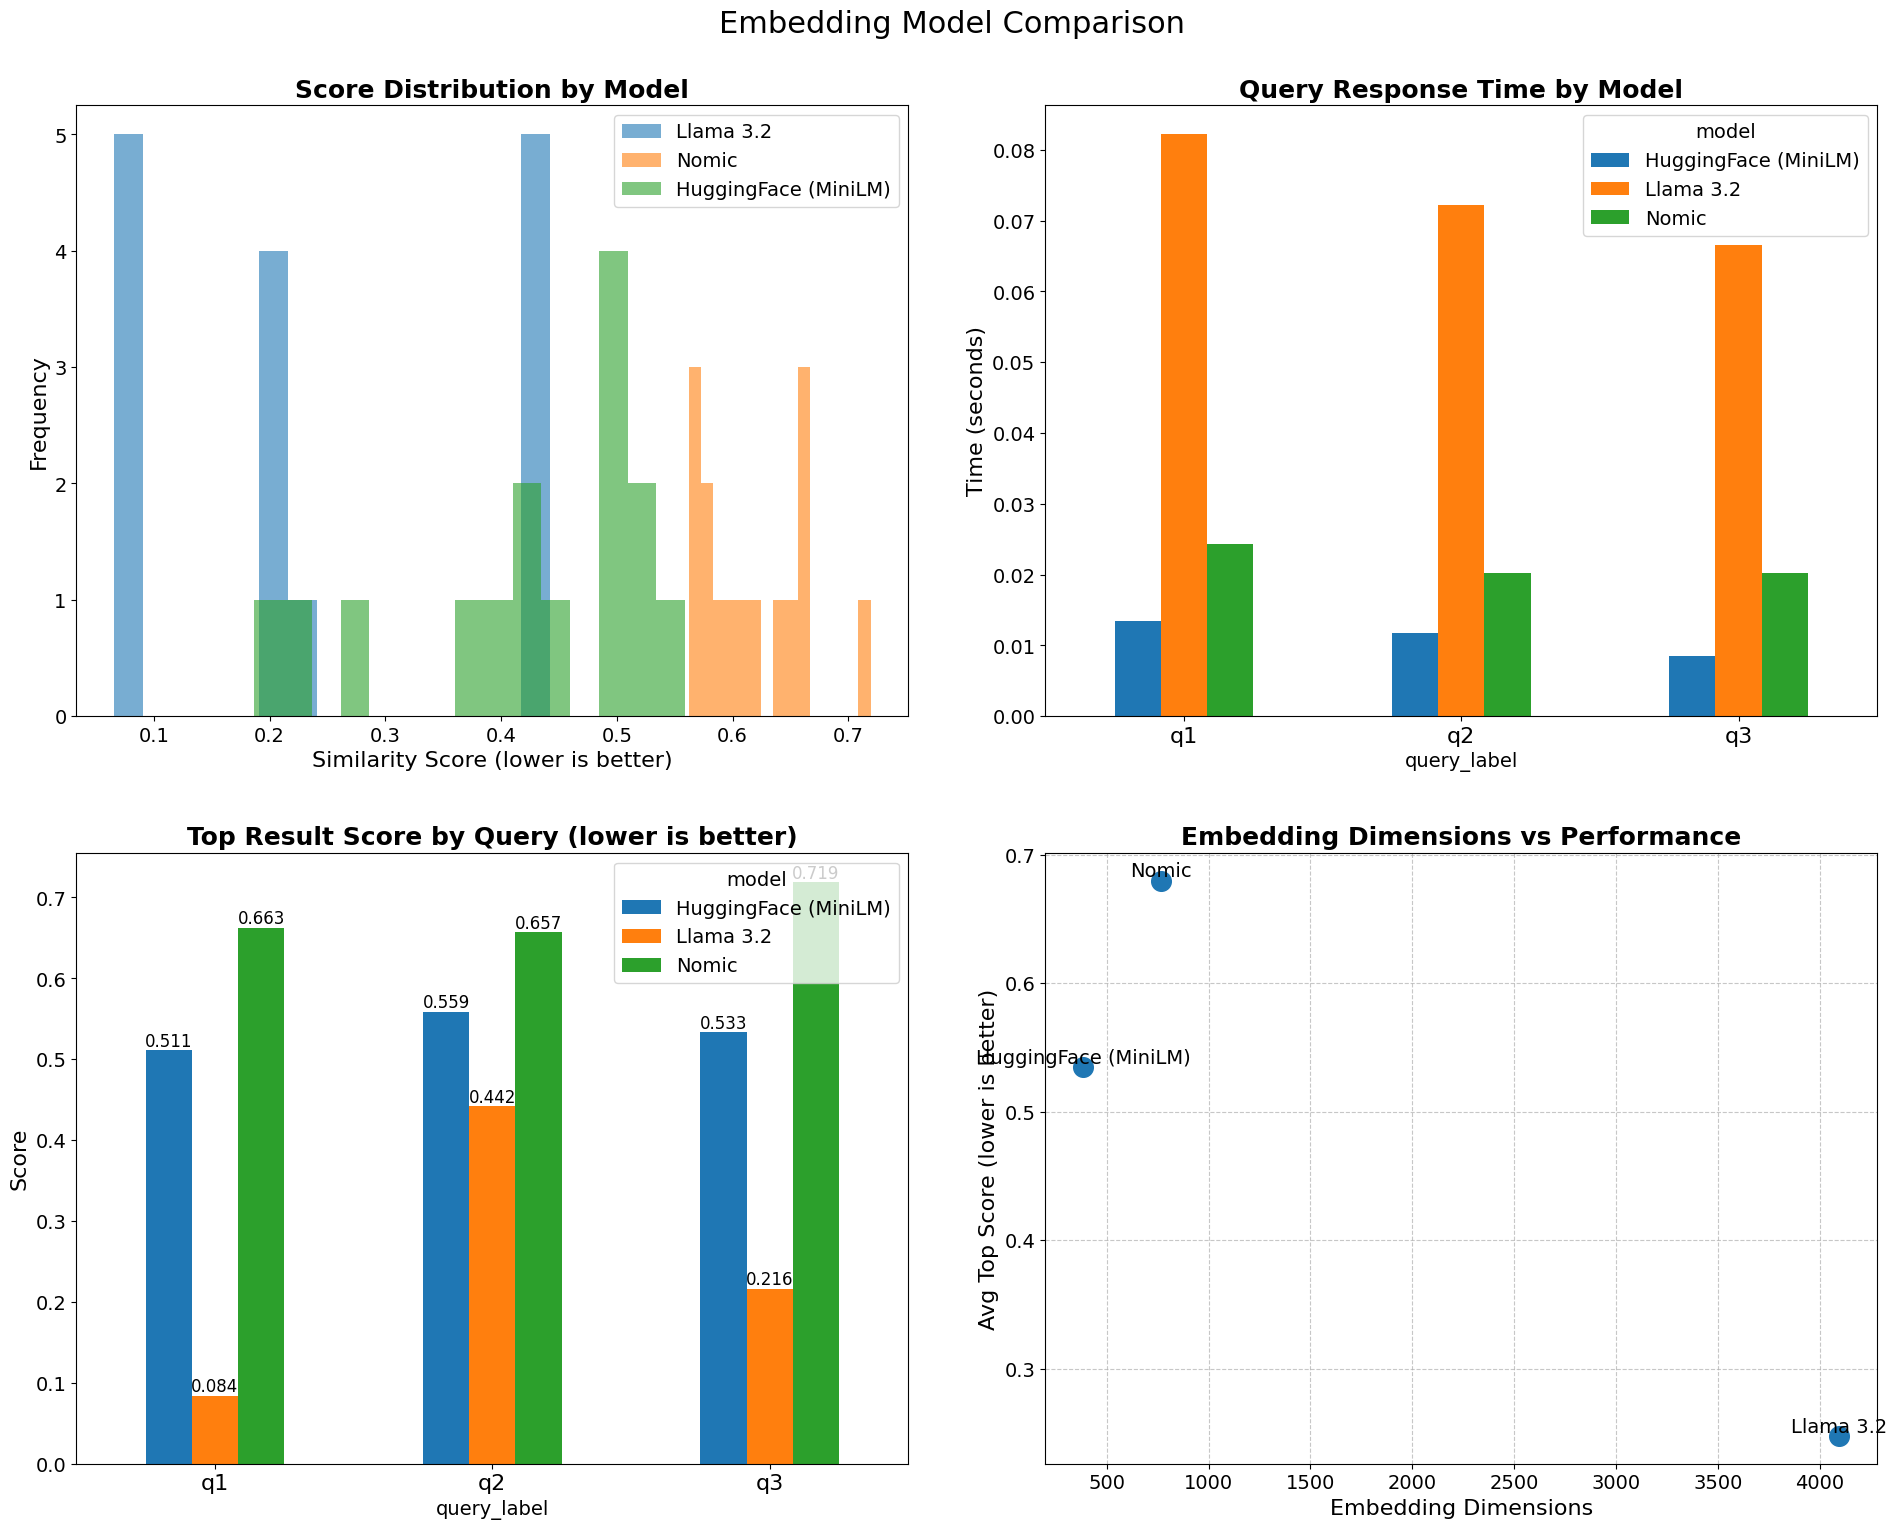

<Figure size 1500x600 with 0 Axes>

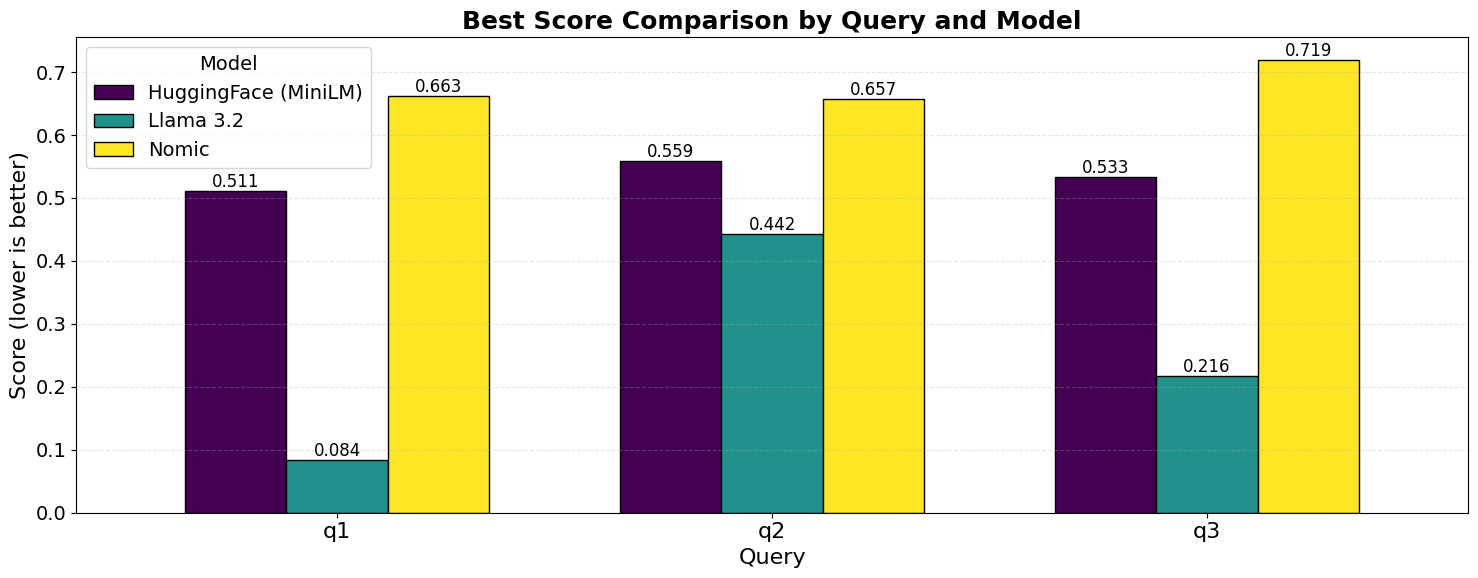

In [26]:
# Create a mapping of queries to shorter labels
query_labels = {}
for i, q in enumerate([q['query'] for q in test_queries]):
    query_labels[q] = f'q{i+1}'

# Convert DataFrame to use query labels instead of full text
results_df_labeled = results_df.copy()
results_df_labeled['query_label'] = results_df['query'].map(query_labels)

# Create advanced visualizations with larger figure size
plt.figure(figsize=(20, 16))
plt.rcParams.update({'font.size': 14})  # Increase font size globally

# 1. Score distribution by model
plt.subplot(2, 2, 1)
for model in results_df['model'].unique():
    model_scores = results_df[results_df['model'] == model]['score']
    plt.hist(model_scores, alpha=0.6, label=model, bins=15)
plt.xlabel('Similarity Score (lower is better)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.title('Score Distribution by Model', fontsize=18, fontweight='bold')
plt.legend(fontsize=14)

# 2. Query time comparison
plt.subplot(2, 2, 2)
query_times = results_df.groupby(['model', 'query'])['query_time'].first().reset_index()
# Add query labels
query_times['query_label'] = query_times['query'].map(query_labels)
pivot_times = query_times.pivot(index='query_label', columns='model', values='query_time')
pivot_times.plot(kind='bar', ax=plt.gca())
plt.title('Query Response Time by Model', fontsize=18, fontweight='bold')
plt.ylabel('Time (seconds)', fontsize=16)
plt.xticks(rotation=0, fontsize=16)  # Horizontal labels with larger font

# 3. Top scores by query and model
plt.subplot(2, 2, 3)
top_scores = results_df[results_df['rank'] == 1].copy()
top_scores['query_label'] = top_scores['query'].map(query_labels)
pivot_scores = top_scores.pivot(index='query_label', columns='model', values='score')
ax = pivot_scores.plot(kind='bar', ax=plt.gca())
plt.title('Top Result Score by Query (lower is better)', fontsize=18, fontweight='bold')
plt.ylabel('Score', fontsize=16)
plt.xticks(rotation=0, fontsize=16)  # Horizontal labels
# Add value labels on bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', fontsize=12)

# 4. Dimensions vs average top score
plt.subplot(2, 2, 4)
model_dims = [embedding_models[m]["dimensions"] for m in results_df['model'].unique()]
avg_top_scores = [results_df[(results_df['model'] == m) & (results_df['rank'] == 1)]['score'].mean()
                 for m in results_df['model'].unique()]
plt.scatter(model_dims, avg_top_scores, s=200)  # Larger scatter points
for i, model in enumerate(results_df['model'].unique()):
    plt.annotate(model, (model_dims[i], avg_top_scores[i]),
                fontsize=14, ha='center', va='bottom')
plt.xlabel('Embedding Dimensions', fontsize=16)
plt.ylabel('Avg Top Score (lower is better)', fontsize=16)
plt.title('Embedding Dimensions vs Performance', fontsize=18, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout(pad=3.0)  # Add more padding between subplots
plt.suptitle('Embedding Model Comparison', fontsize=22, y=0.98)
plt.subplots_adjust(top=0.92)  # Make room for the suptitle
plt.show()

# Create a bonus plot - side-by-side comparison of models across queries
plt.figure(figsize=(15, 6))
# Group by query label and model, get the top (rank=1) score for each
query_model_scores = results_df_labeled[results_df_labeled['rank'] == 1].pivot(
    index='query_label', columns='model', values='score')

# Plot with custom colors and hatches for better differentiation
ax = query_model_scores.plot(kind='bar', width=0.7, figsize=(15, 6),
                            colormap='viridis', edgecolor='black', linewidth=1)

plt.title('Best Score Comparison by Query and Model', fontsize=18, fontweight='bold')
plt.xlabel('Query', fontsize=16)
plt.ylabel('Score (lower is better)', fontsize=16)
plt.xticks(rotation=0, fontsize=16)
plt.legend(fontsize=14, title='Model', title_fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Add value labels on bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', fontsize=12)

plt.tight_layout()
plt.show()